In [ ]:
depth = 10_000

In [ ]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns

from scipy.stats import pearsonr

sns.set_style("darkgrid")
np.random.seed(930525)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)

warnings.simplefilter('once')

%matplotlib inline
%load_ext watermark
%watermark --iversions

pandas  1.1.4
numpy   1.20.1
seaborn 0.10.1



In [4]:
import requests

from io import StringIO

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
from collections import defaultdict

url = requests.get('https://docs.google.com/spreadsheets/d/1KO_wGiEagJ8PMO2BzSDI1IXHYO4RHZMMSWXlT48peiQ/export?format=csv')
csv_raw = StringIO(url.text)
df_truth = pd.read_csv(csv_raw)

inf_tax_file = "/mnt/btrfs/data/gtdb_95/gtdb_genomes_reps_r95/r95.gtdb.tax"

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
df_tax = pd.read_csv(inf_tax_file, names=["assembly_accession", "tax"], sep="\t")

df_tax["species"] = [";".join(_.split(";")[:7]) for _ in df_tax.tax]
df_tax["genus"] = [";".join(_.split(";")[:6]) for _ in df_tax.tax]
df_tax["family"] = [";".join(_.split(";")[:5]) for _ in df_tax.tax]

accession_to_genus = dict()
for t in df_tax.itertuples():
    accession_to_genus[t.assembly_accession] = t.genus.split(";")[-1]

In [7]:
from glob import glob
import os

files = glob(f"/mnt/btrfs/data/type_1/species_mc/b6_capitalist_split_by_sample/*.{depth}.extra.csv")

dfs = []
for file in files:
    name = '_'.join(os.path.basename(file).split('.')[:-4])
    df = pd.read_csv(file, index_col = 0)
    df['dataset'] = name
    dfs.append(df)
df_type_1_features = pd.concat(dfs)

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (84,88,97,106,218,222,231,240) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
# Build the true species accessions
dd = defaultdict(set)

dd_genus = defaultdict(set)
for group, df in df_truth.groupby('dataset'):
    mask_nan = df_truth['database_accession'].astype(str) == 'nan'
    
    for row in df.loc[mask_nan].itertuples():
        # get the genus of the nans
        dd_genus[group].add("g__" + row.name.replace("_", " ").split()[0])
        dd_genus[group].add("g__" + row.homotypic_synonym.replace("_", " ").split()[0])
    
    dd[group] = set(df.loc[~mask_nan, "database_accession"].values)

In [9]:
df_type_1_features.groupby('dataset').size()

dataset
dual_index        771
gis_20           2167
hmp_even         2016
hmp_staggered    1207
mbarc_26          961
zymo_even         750
zymo_log          894
dtype: int64

In [10]:
rows = []
for i, t in df_type_1_features.iterrows():
    if t['assembly_accession'] in dd[t['dataset']]:
        rows.append(True)
    else:
        rows.append(False)
df_type_1_features["truth"] = rows

In [11]:
df_type_1_features['join'] = df_type_1_features['tree_closest_assembly_accession'] + "_" + df_type_1_features['dataset']

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import PredefinedSplit

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
features = ['hits',
 'percent_coverage',
 'mean_coverage',
 'sd_coverage',
 'percent_binned_coverage',
 'mean_binned_coverage',
 'sd_binned_coverage',
 'expected_percent_coverage',
 'shannon_entropy',
 'percent_max_uncovered_region',
 'largest_pileup',
 'largest_binned_pileup',
 'gc_content',
 'total_genome_length',
 'ungapped_genome_length',
 'num_n_groups',
 'consecutive_ns',
 'tree_dist',
 'tree_top_dist',
 'gf_checkm_completeness',
 'gf_checkm_contamination',
 'relative_abundance',
 'tree_hits',
 'tree_percent_coverage',
 'tree_mean_coverage',
 'tree_sd_coverage',
 'tree_percent_binned_coverage',
 'tree_mean_binned_coverage',
 'tree_sd_binned_coverage',
 'tree_expected_percent_coverage',
 'tree_shannon_entropy',
 'tree_percent_max_uncovered_region',
 'tree_largest_pileup',
 'tree_largest_binned_pileup',
 'tree_dist',
 'tree_top_dist'
]

# features = [
#  'gf_checkm_completeness',
#  'gf_checkm_contamination',
#  'tree_relative_abundance'
# ]

# features = ['relative_abundance']

In [15]:
df_type_1_features['relative_abundance'] = df_type_1_features['hits'] / df_type_1_features.groupby('dataset')['hits'].transform('sum')

df_type_1_features.reset_index(inplace=True, drop=True)
df_type_1_features['dataset_cat'] = pd.Series([_.split("_")[0] for _ in df_type_1_features['dataset']], dtype='category')

categories = df_type_1_features['dataset_cat'].cat.categories

X = df_type_1_features[features + ["assembly_accession", "dataset", "truth", "dataset_cat"]]

# X = X.replace([np.inf, -np.inf], np.nan)
# X = X.loc[:, features].dropna()

cv = PredefinedSplit(X['dataset_cat'].cat.codes)
X = X.loc[:, features].copy()
X.reset_index(inplace=True, drop=True)

y = df_type_1_features.loc[:, "truth"]
y.reset_index(inplace=True, drop=True)

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV

In [17]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold

precisions = []
average_precisions = []
mean_recall = np.linspace(0, 1, 100)
classifiers = []

# X_transf = rfecv.transform(X)
X_transf = X.copy().values
# X_transf = X.copy().values
# X.reset_index(inplace=True, drop=True)
y.reset_index(inplace=True, drop=True)

for i, (train, test) in enumerate(cv.split(X_transf, y)):
#     clf = RandomForestClassifier(n_estimators=100, max_features=.2, min_samples_leaf=17, min_samples_split=9, bootstrap=False, criterion="gini", class_weight="balanced_subsample")
#     clf = ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='entropy', max_features=0.8, min_samples_leaf=4, min_samples_split=20, n_estimators=100)
    clf = make_pipeline(
            MinMaxScaler(),
            RFECV(LogisticRegression(penalty="l1", solver="liblinear", fit_intercept=True, dual=False, tol=0.001, class_weight="balanced"), step=1, cv=StratifiedKFold(random_state=930525, shuffle=True), scoring="f1", min_features_to_select=5, n_jobs=40),
            MLPClassifier(alpha=0.01, learning_rate_init=0.01)
        )

#     clf = LogisticRegression(penalty="l1", solver="liblinear", fit_intercept=True, dual=False, tol=0.001, class_weight="balanced")
    clf.fit(X_transf[train], y.loc[train])
    classifiers.append(clf)

In [18]:
import joblib

for i, classifier in enumerate(classifiers):
    joblib.dump(classifier, f'../data/clf.sklearn.{categories[i]}.{depth}.pkl', compress=9)
    
joblib.dump(X, f'../data/X.{depth}.pkl', compress=9)
joblib.dump(y, f'../data/y{depth}.pkl', compress=9)

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['../data/y10000.pkl']

Dataset: dual
F1: 0.9500000000000001
Precision: 0.9047619047619048
Recall: 1.0
Num Predicted: 21
Dataset: gis
F1: 0.8260869565217391
Precision: 0.7037037037037037
Recall: 1.0
Num Predicted: 27
Dataset: hmp
F1: 0.7826086956521738
Precision: 0.9310344827586207
Recall: 0.675
Num Predicted: 29
Dataset: mbarc
F1: 0.9411764705882353
Precision: 0.96
Recall: 0.9230769230769231
Num Predicted: 25
Dataset: zymo
F1: 0.8571428571428571
Precision: 1.0
Recall: 0.75
Num Predicted: 12


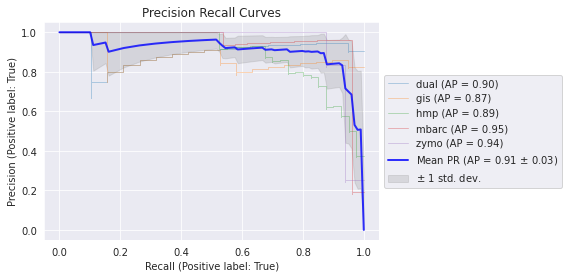

In [19]:
fig, ax = plt.subplots()

columns = ['depth', 'dataset', 'precision', 'recall', 'f1', 'ap', 'tp', 'tn', 'fp', 'fn']
rows = []
for i, ((train, test), classifier) in enumerate(zip(cv.split(X_transf, y), classifiers)):
    viz = plot_precision_recall_curve(classifier, X_transf[test], y.loc[test],
                     name=f'{categories[i]}',
                     alpha=0.3, lw=1, ax=ax)
    interp_precision = np.interp(mean_recall, viz.recall[::-1], viz.precision[::-1])
    interp_precision[0] = 1.0
    precisions.append(interp_precision)
    average_precisions.append(viz.average_precision)
    y_pred = classifier.predict(X_transf[test])
    print(f"Dataset: {categories[i]}")
    print(f"F1: {f1_score(y.loc[test], y_pred)}")
    print(f"Precision: {precision_score(y.loc[test], y_pred)}")
    print(f"Recall: {recall_score(y.loc[test], y_pred)}")
    print(f"Num Predicted: {y_pred.sum()}")
    
    row = [
        depth,
        categories[i],
        precision_score(y.loc[test], y_pred),
        recall_score(y.loc[test], y_pred),
        f1_score(y.loc[test], y_pred),
        viz.average_precision,
        (y_pred[y.loc[test]]).sum(),
        (~y_pred[~y.loc[test]]).sum(),
        (y_pred[~y.loc[test]]).sum(),
        (~y_pred[y.loc[test]]).sum()
    ]
    rows.append(row)

mean_precision = np.mean(precisions, axis=0)
mean_precision[-1] = 0.0
mean_average_precisions = np.mean(average_precisions)
std_average_precisions = np.std(average_precisions)

ax.plot(mean_recall, mean_precision, color='b',
        label=r'Mean PR (AP = %0.2f $\pm$ %0.2f)' % (mean_average_precisions, std_average_precisions),
        lw=2, alpha=.8)

# calculate the no skill line as the proportion of the positive class
# no_skill = len(y[y==False]) / len(y)
# # plot the no skill precision-recall curve
# plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'No Skill ( AP = {no_skill:.5f})')

std_precisions = np.std(precisions, axis=0)
precisions_upper = np.minimum(mean_precision + std_precisions, 1)
precisions_lower = np.maximum(mean_precision - std_precisions, 0)
ax.fill_between(mean_recall, precisions_lower, precisions_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Precision Recall Curves")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

df_results = pd.DataFrame(rows, columns=columns)

df_results.to_csv(f"../data/results.{depth}.csv")